In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('../drinking_water_potability.csv')
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

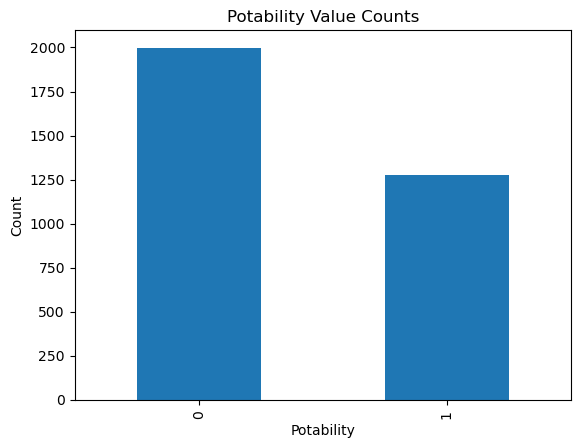

Potability
0    1998
1    1278
Name: count, dtype: int64


In [17]:
df['Potability'].value_counts().plot(kind='bar')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Potability Value Counts')
plt.show()
print(df['Potability'].value_counts())

## **Balanceo de clases**

In [18]:
from sklearn.utils import resample

df_majority = df[df.Potability==0]
df_minority = df[df.Potability==1]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [20]:
df_balanced['Potability'].value_counts().plot(kind='bar')

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
416,6.262799,206.889748,31414.525810,4.528076,349.734662,567.027274,15.963540,73.022605,4.012518,0
512,7.803833,223.688111,37376.792990,6.664969,333.775777,343.764013,16.697408,74.782434,2.907387,0
458,8.692115,144.236358,2552.962804,9.202634,347.975137,517.427471,13.963421,42.388661,2.283475,0
901,7.344976,182.306942,5689.804405,6.764350,373.872785,360.184473,20.483902,73.488981,3.418763,0
2087,6.527441,181.072995,22444.081780,10.474977,271.862792,351.063788,11.996365,66.396293,3.567181,0


## **Predictorias y targets**

In [21]:
X = df_balanced.drop('Potability', axis=1)
y = df_balanced['Potability']

## **Perparación de datos**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

object_columns = X.select_dtypes(include=['object']).columns

enc = OneHotEncoder(sparse=False, drop='first')

X_encoded = pd.DataFrame(enc.fit_transform(X[object_columns]))
X_encoded.columns = enc.get_feature_names(object_columns)

X = X.drop(object_columns, axis=1).reset_index(drop=True)

In [ ]:
X = pd.concat([X, X_encoded], axis=1)
X.dropna(columns = ['index'], inplace = True)

In [ ]:
X

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = X.columns
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [25]:
X_scaled

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.453314,0.578391,0.510515,0.326894,0.627033,0.731939,0.554831,0.559872,0.480353
1,0.569061,0.639323,0.608408,0.494166,0.581699,0.308083,0.584415,0.575066,0.269723
2,0.635780,0.351132,0.036647,0.692809,0.622034,0.637776,0.474203,0.295386,0.150810
3,0.534596,0.489223,0.088150,0.501945,0.695601,0.339256,0.737055,0.563899,0.367187
4,0.473191,0.484747,0.363233,0.792405,0.405825,0.321941,0.394908,0.502662,0.395475
...,...,...,...,...,...,...,...,...,...
2551,0.333535,0.530482,0.775947,0.533436,0.656047,0.654856,0.471422,0.505178,0.561031
2552,0.569439,0.530016,0.279263,0.603473,0.581699,0.400510,0.713647,0.502662,0.248921
2553,0.690415,0.465486,0.539101,0.547807,0.581699,0.475680,0.356318,0.532441,0.344338
2554,0.367986,0.664407,0.191490,0.465860,0.581699,0.420318,0.361553,0.598427,0.613032


## **Separación de train y test**

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## **Función para medir el error**

In [27]:
from sklearn.metrics import roc_auc_score

def mide_error(model_name, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    print(f'{model_name} AUC: {auc:.4f}')

# **3. Dataset para series temporales**

## **3.1 Carga de ficheros**

In [ ]:
import statsmodels.api as sm

df_st = sm.datasets.macrodata.load_pandas().data.loc[:, ['year', 'quarter','infl']]
df_st['period'] = pd.PeriodIndex(year=df_st.year, quarter=df_st.quarter, freq='Q')
df_st.set_index('period', inplace=True)
df_st.drop(['year', 'quarter'], axis=1, inplace=True)
df_st.head()

## **3.2 Separación de train y test**

In [ ]:
train_data = df_st.iloc[:len(X_train)]
test_data = df_st.iloc[len(X_train):]
train_data = train_data['infl'].values.astype(np.float64)

# **4 Regresión logistica**
------


In [51]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict_proba(X_test)[:, 1]

mide_error('Logistic Regression', y_pred)

Logistic Regression AUC: 0.5231


# **5 KNN**

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)

y_pred = knn.predict_proba(X_test)[:, 1]

mide_error('KNN', y_pred)


KNN AUC: 0.3407


# **6 Naive bayes**

In [70]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

nb_G = GaussianNB()
nb_G.fit(X_train, y_train)

nb_B = BernoulliNB()
nb_B.fit(X_train, y_train)

nb_M = MultinomialNB()
nb_M.fit(X_train, y_train)

y_pred_G = nb_G.predict_proba(X_test)[:, 1]
y_pred_B = nb_B.predict_proba(X_test)[:, 1]
y_pred_M = nb_M.predict_proba(X_test)[:, 1]

mide_error('Naive Bayes Gaussian', y_pred_G)
mide_error('Naive Bayes Bernoulli', y_pred_B)
mide_error('Naive Bayes Multinomial', y_pred_M)

Naive Bayes Gaussian AUC: 0.5948
Naive Bayes Bernoulli AUC: 0.5019
Naive Bayes Multinomial AUC: 0.5142


# **7 K-Medias**

In [135]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=16, random_state=42, n_init=10, max_iter=300, tol=0.0001, algorithm='auto')

kmeans.fit(X_train)

y_pred = kmeans.predict(X_test)


mide_error('KMeans', y_pred)
# kmeans.labels_[:10] # first 10 cluster labels of the training set (cuando no hay variable ojetivo)

c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans AUC: 0.5228


# **8 Árbol de desiciones**

In [133]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=8, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict_proba(X_test)[:, 1]

mide_error('Decision Tree', y_pred)

Decision Tree AUC: 0.6156


# **9 Arima** 
---------
(Cuando los datos son son estacionales)

In [ ]:
from pmarima import auto_arima

model = auto_arima(train_data, 
                   seasonal=True, 
                   m=4, 
                   max_p=3, 
                   max_q=3, 
                   max_P=3, 
                   max_Q=3, 
                   max_order=None, 
                   max_d=2, 
                   max_D=1, 
                   maxiter=50, 
                   alpha=0.05, 
                   n_jobs=-1, 
                   trend='ct', 
                   information_criterion='aic', 
                   out_of_sample_size=0, 
                   scoring='mse', 
                   scoring_args=None, 
                   start_p=2, 
                   start_q=2, 
                   start_P=1, 
                   start_Q=1, 
                   start_order=None, 
                   seasonal_test='ocsb', 
                   stepwise=True, 
                   suppress_warnings=True, 
                   error_action='trace', 
                   trace=False, 
                   random=False, 
                   random_state=None, 
                   n_fits=10, 
                   return_valid_fits=False, 
                   out_of_sample_size=0, 
                   scoring='mse', 
                   scoring_args=None, 
                   with_intercept=True, 
                   sarimax_kwargs=None)
model_fit = model.fit(train_data)
predictions = model_fit.predict(n_periods=len(test_data))

mide_error('ARIMA', predictions)
plt.figure(figsize=(10, 6))
plt.plot(df_st[-12:].index.strftime('%Y-%m'), df_st[-12:].infl, label='Reality')
plt.plot(df_st[-4].index.strftime('%Y-%m'), predictions, label='Predictions')
plt.xticks(rotation=45, fontsize=12);


# **10 Suavizado exponencial**


In [ ]:
from statsmodels.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train_data, trend='add', seasonal=None, seasonal_periods=4)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

plt.figure(figsize=(10, 6))
plt.plot(df_st[-12:].index.strftime('%Y-%m'), df_st[-12:].infl, label='Reality')
plt.plot(df_st[-4].index.strftime('%Y-%m'), predictions, label='Predictions')
plt.xticks(rotation=45, fontsize=12);

# **11 Random Forest**

In [152]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=14, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:, 1]

mide_error('Random Forest', y_pred)

Random Forest AUC: 0.6924


# **12 XGBOOST**

In [ ]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(n_estimators=100, max_depth=14, random_state=42)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict_proba(X_test)[:, 1]

mide_error('XGBoost', y_pred)

# **13 LIGHTGBM**

In [156]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boosting = HistGradientBoostingClassifier(max_iter=100, max_depth=10, random_state=42)
hist_gradient_boosting.fit(X_train, y_train)

y_pred = hist_gradient_boosting.predict_proba(X_test)[:, 1]

mide_error('Hist Gradient Boosting', y_pred)

Hist Gradient Boosting AUC: 0.6822


# **14 SVM**

In [174]:
from sklearn.svm import SVC

svc = SVC(probability=True, 
          random_state=42, 
          kernel='rbf', 
          C=2.0, 
          gamma='scale', 
          degree=3, 
          coef0=0.0, 
          shrinking=True, 
          tol=0.001, 
          cache_size=400, 
          class_weight=None)
svc.fit(X_train, y_train)

y_pred = svc.predict_proba(X_test)[:, 1]

mide_error('SVC', y_pred)

SVC AUC: 0.7028
